In [1]:
import pandas as pd
import numpy as np
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt
import statistics as stat

from matplotlib.font_manager import FontProperties
from bokeh.plotting import figure, output_file, show
from sklearn.cluster import KMeans
from sklearn.manifold import MDS
from sklearn.cluster import AgglomerativeClustering
from sklearn import manifold
from sklearn.decomposition import PCA
from sqlalchemy import create_engine
from sqlalchemy.ext.automap import automap_base

%matplotlib inline
plt.rcParams['axes.unicode_minus']=False
engine = create_engine('sqlite:///fund.db')

In [2]:
def getTimeStamp(date):
    return int(pd.read_sql(sql='select strftime("%s",?)', con=engine, params=[date]).loc[0][0])

In [3]:
def getNAV(names,start,end):
#     start = getTimeStamp(start)
#     end = getTimeStamp(end)
    data = pd.read_sql(sql='select * from price where date between ? and ? order by date asc',
                       con=engine,index_col='date', params=[start,end])
    date = pd.read_sql(sql='select distinct date from price where date between ? and ? order by date asc',
                       con=engine,index_col='date', params=[start,end]).index
    NAV = np.zeros((len(names),len(date)))
    for j in range (len(names)):
        temp = data[data['id'] == names[j]]
        NAV[j][0] = temp.iloc[0]['NAV']
        for i,day in enumerate(date[1:]):
            try:
                NAV[j][i+1] = temp.loc[day]['NAV']
            except:
                NAV[j][i+1] = NAV[j][i]
    return NAV

In [4]:
def poolDecide(year):
    start = getTimeStamp(year + '-12-01')
    end = getTimeStamp(year + '-12-31')
    names = pd.read_sql(sql='select distinct id from price where date between ? and ?',
                        con=engine, params=[start,end])
    names = names['id'].sample(n=300).values
    return names

In [5]:
year = input("請輸入欲回測年：")
past_year = str(int(year)-1)
start = getTimeStamp(year+'-01-01')
end = getTimeStamp(year+'-12-31')

請輸入欲回測年：2017


# 0. 抓出0050各項數據

## 一. 淨值

In [6]:
NAV_0050 = getNAV(['0050 元大台灣50'], start, end)[0]

In [7]:
NAV_0050

array([72.03, 72.07, 72.58, 72.75, 72.56, 72.61, 72.47, 73.14, 72.78,
       72.05, 72.54, 72.25, 72.05, 72.19, 73.07, 73.18, 72.84, 72.89,
       73.4 , 73.63, 71.76, 72.14, 72.88, 73.26, 73.27, 73.9 , 73.66,
       73.48, 73.48, 73.37, 73.48, 73.39, 73.34, 73.2 , 72.44, 72.64,
       72.13, 72.33, 72.78, 72.96, 72.17, 72.03, 72.68, 72.96, 72.98,
       73.87, 74.36, 74.36, 75.05, 74.57, 74.58, 74.33, 74.39, 74.52,
       74.13, 73.97, 73.57, 75.01, 74.5 , 74.21, 74.28, 74.16, 74.18,
       74.33, 73.72, 73.6 , 73.63, 72.83, 72.85, 73.59, 73.69, 74.62,
       74.54, 74.59, 74.74, 75.38, 75.67, 75.68, 75.19, 75.82, 75.97,
       76.21, 76.59, 76.24, 76.58, 76.5 , 76.37, 76.01, 75.77, 76.17,
       76.29, 76.5 , 77.09, 77.06, 76.27, 76.81, 77.35, 77.33, 78.01,
       77.75, 77.9 , 78.02, 77.82, 76.85, 77.04, 76.83, 76.97, 77.56,
       78.42, 79.41, 79.32, 79.79, 79.67, 81.58, 81.3 , 80.45, 80.86,
       80.49, 80.76, 80.09, 80.81, 80.64, 80.04, 80.13, 81.65, 81.66,
       82.39, 82.14,

## 二.配息

In [8]:
interest_0050 = (pd.read_sql(sql='select interest from interest where date between ? and ? and id = "0050 元大台灣50"'
                                ,con = engine, params=[start,end])['interest'].sum())

In [9]:
interest_0050

2.4

## 三. 漲跌幅

In [10]:
rate_0050 = []
rate_0050.append(0)
for i in range (len(NAV_0050)-1):
    rate_0050.append((NAV_0050[i+1] - NAV_0050[i]) / NAV_0050[i])

In [11]:
rate_0050

[0,
 0.0005553241704844098,
 0.007076453448036703,
 0.0023422430421603984,
 -0.0026116838487972196,
 0.0006890848952590567,
 -0.0019281090758848723,
 0.009245204912377559,
 -0.004922067268252658,
 -0.010030228084638692,
 0.006800832755031355,
 -0.003997794320375051,
 -0.0027681660899654373,
 0.0019430950728660731,
 0.012190054024102998,
 0.0015054057752841611,
 -0.004646078163432678,
 0.000686436024162509,
 0.006996844560296407,
 0.003133514986375882,
 -0.02539725655303532,
 0.005295429208472623,
 0.0102578319933462,
 0.005214050493962811,
 0.00013650013650001234,
 0.008598334925617712,
 -0.0032476319350474843,
 -0.0024436600597338124,
 0.0,
 -0.0014970059880239444,
 0.0014992503748125858,
 -0.0012248230811105526,
 -0.0006812917291183697,
 -0.0019089173711480851,
 -0.010382513661202256,
 0.002760905577029305,
 -0.007020925110132229,
 0.0027727713849993465,
 0.006221484861053544,
 0.0024732069249792884,
 -0.010827850877192874,
 -0.0019398642095053425,
 0.009024017770373535,
 0.003852504

## 四. 收益率

In [12]:
profit_0050 = []
for i in range(len(NAV_0050)):
    profit_0050.append((NAV_0050[i] - NAV_0050[0]) / NAV_0050[0] * 100)
profit_0050[-1] += interest_0050

In [13]:
profit_0050

[0.0,
 0.05553241704844099,
 0.7635707344162115,
 0.9995835068721349,
 0.7358045258919911,
 0.8052200472025521,
 0.6108565875329692,
 1.541024573094543,
 1.0412328196584755,
 0.027766208524220494,
 0.7080383173677705,
 0.3054282937664846,
 0.027766208524220494,
 0.2221296681938034,
 1.4438428432597417,
 1.5965569901430037,
 1.1245314452311568,
 1.193946966541718,
 1.9019852839094884,
 2.2212966819380733,
 -0.37484381507704573,
 0.1527141468832423,
 1.1800638622795978,
 1.7076218242399057,
 1.7215049285020059,
 2.596140497015139,
 2.262945994724414,
 2.0130501180063898,
 2.0130501180063898,
 1.860335971123148,
 2.0130501180063898,
 1.8881021796473683,
 1.8186866583368073,
 1.6243231986672244,
 0.5692072747466286,
 0.8468693599888928,
 0.1388310426211222,
 0.41649312786338627,
 1.0412328196584755,
 1.2911286963764996,
 0.1943634596695829,
 0.0,
 0.9024017770373535,
 1.2911286963764996,
 1.3188949049007397,
 2.554491184228798,
 3.2347632930723282,
 3.2347632930723282,
 4.192697487158123,


# 1. 決定基金池

In [14]:
start = getTimeStamp(past_year + '-12-01')
end = getTimeStamp(past_year + '-12-31')
names = pd.read_sql(sql='select distinct id from price where date between ? and ?',
                        con=engine, params=[start,end])
names = names['id'].sample(n=300).values

In [15]:
names

array(['PLZ54 霸菱全新興Aed', 'PYZU0 施羅環歐收CaEU', 'ANZ72 安本日本小型I2$h',
       'T0326A 第一金全球不動 A', 'T2045E 日盛中國高收債A$', 'MSZ16 摩士可換新興 A$',
       'PAZR2 法百全高收MD$', 'PYZD3 施羅德新歐A1a$', 'PIZA9 鋒裕新興債B2e',
       'AIZ51 柏瑞日本Aa$', 'FLZB2 富蘭坦金磚$B.a', 'UOB40 大華新興債USD',
       'PYZM6 施羅德亞債Ad$', 'T2280B 復華南非幣短收 B', 'FPZ27 法盛盧賽債I/A$',
       'MFZD8 MFS全盛歐研A1$', 'UOB20 大華亞洲$', 'CRZ02 凱敏多元配置Ea$h',
       'T2031Y 日盛全球抗暖化', 'MFZG4 MFS歐價值A1-USD', 'MGA15 M&G全未來趨勢A$',
       'FSZ10 首域盈信新興市場', 'T1026B 富邦全球不動產 $', 'GAZ26 GAM 日本-A JPY',
       'AIZ25 柏瑞美研增Ya$', 'GSF88 天達環策管C2mh', 'AFZ14 鋒裕歐元高債SEMD',
       'T2038C 日盛亞洲高收債AC', 'T4123B 凱基護城河基金$', 'MFZF0 MFS美價值A1-USD',
       'T0830Y 保德信拉丁美洲', 'MFZ21 MFS重點研究A1$', 'ALZQ8 聯博全球價B美元',
       'ANZ89 安本新興司債X-2', 'TLZ24 安聯韓國基金', 'T0751F 瀚亞全球策收股BC',
       'UOB04 大華全球金融', 'PIZE5 鋒裕策收益I2', 'NBZ24 NB高收債T$dw',
       'POZ12 羅素高收債AUDH-B', 'ALZ95 聯博美收S USD', 'INZ55 NN 歐新興Pe',
       'AIZ27 柏瑞日新遠景A', 'JAZ34 駿利美創業BE.ac', 'PTZ16 百達歐小企業Re',
       'PLZ72 霸菱熟新高債I$a', 'ALZIA 聯博全高債SA$m',

# 抓出淨值

In [16]:
NAV = getNAV(names, start, end)

In [17]:
NAV

array([[27.06  , 27.06  , 27.02  , ..., 27.23  , 27.23  , 27.23  ],
       [20.6602, 20.6602, 20.8309, ..., 21.783 , 21.783 , 21.783 ],
       [ 8.8679,  8.8679,  8.8668, ...,  9.1575,  9.1575,  9.1575],
       ...,
       [10.24  , 10.24  , 10.32  , ..., 10.57  , 10.57  , 10.57  ],
       [ 9.7351,  9.7618,  9.7837, ...,  9.8875,  9.9136,  9.9171],
       [ 8.8317,  8.7983,  8.7808, ...,  8.6838,  8.697 ,  8.732 ]])

# 2.抓出Features

## 一. 抓出漲跌幅

In [18]:
length = len(NAV[0])-1
rate = np.zeros((len(names),length))
for j in range (len(names)):
    for i in range (length):
        rate[j][i] = (NAV[j][i+1] - NAV[j][i]) / NAV[j][i]

In [19]:
rate

array([[ 0.00000000e+00, -1.47819660e-03,  1.48038490e-03, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  8.26226271e-03,  7.39286349e-03, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -1.24042896e-04, -4.74804890e-03, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  7.81250000e-03, -7.75193798e-03, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.74265287e-03,  2.24343871e-03,  2.98455595e-03, ...,
         6.57828155e-04,  2.63969659e-03,  3.53050355e-04],
       [-3.78183136e-03, -1.98902061e-03,  1.13884840e-05, ...,
         6.08251364e-03,  1.52007186e-03,  4.02437622e-03]])

## 二. 刪除協方差為零之基金

In [20]:
temp = []
for i,j in enumerate(rate):
    if np.cov(j) == 0:
        temp.append(i)

rate = np.delete(rate,temp,0)
names = np.delete(names,temp,0)
NAV = np.delete(NAV,temp,0)

## 三. 計算相關係數

In [21]:
similarity = np.zeros((len(rate),len(rate)))
for i in range(len(rate)):
    for j in range(len(rate)):
        corr = np.corrcoef(rate[i], rate[j])[0][-1]
        similarity[i][j] = 1-(corr*0.5+0.5)
for i in range(len(rate)):
    similarity[i][i] = 0

In [22]:
similarity

array([[0.        , 0.30378145, 0.36668446, ..., 0.32168745, 0.43232669,
        0.43264561],
       [0.30378145, 0.        , 0.44415068, ..., 0.30798879, 0.4926902 ,
        0.47086532],
       [0.36668446, 0.44415068, 0.        , ..., 0.3277701 , 0.48630356,
        0.68357152],
       ...,
       [0.32168745, 0.30798879, 0.3277701 , ..., 0.        , 0.49697737,
        0.65759146],
       [0.43232669, 0.4926902 , 0.48630356, ..., 0.49697737, 0.        ,
        0.42040837],
       [0.43264561, 0.47086532, 0.68357152, ..., 0.65759146, 0.42040837,
        0.        ]])

In [23]:
features = []
for i in range (len(NAV)): 
    features.append(np.append(similarity[i], np.std(NAV[i], ddof=1)))

In [24]:
features

[array([0.        , 0.30378145, 0.36668446, 0.47026907, 0.39434021,
        0.44070133, 0.67959744, 0.52777038, 0.23305912, 0.53355999,
        0.32267374, 0.56931951, 0.53794403, 0.52673614, 0.5013911 ,
        0.34447087, 0.43625854, 0.20293681, 0.30921774, 0.31257965,
        0.58280656, 0.46920271, 0.50405053, 0.40557091, 0.24363798,
        0.3474122 , 0.38046329, 0.43168533, 0.30009818, 0.21933611,
        0.33265377, 0.28843006, 0.2421324 , 0.4741204 , 0.58292326,
        0.30094014, 0.28052046, 0.68893285, 0.32621971, 0.45251308,
        0.58847036, 0.33833485, 0.48172785, 0.29231441, 0.19573845,
        0.4016187 , 0.52933573, 0.57126569, 0.36985768, 0.20101796,
        0.32245783, 0.55670167, 0.75892648, 0.74664033, 0.42838787,
        0.44506513, 0.58614281, 0.34315552, 0.38897767, 0.58393917,
        0.25970208, 0.28980822, 0.28675831, 0.37031148, 0.35086555,
        0.60142743, 0.6619173 , 0.41106591, 0.39324178, 0.30292304,
        0.36200701, 0.3751264 , 0.45545773, 0.26

# 4.進行分群

In [25]:
clustering = KMeans(n_clusters=4, n_jobs=-1).fit(rate)

In [26]:
clustering.labels_

array([2, 2, 0, 1, 0, 1, 1, 1, 2, 1, 3, 0, 0, 0, 0, 0, 3, 2, 0, 0, 1, 1,
       1, 2, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 3, 0, 2, 0, 0, 0, 0, 2, 3, 2,
       2, 0, 0, 0, 1, 2, 3, 0, 1, 0, 0, 3, 0, 2, 0, 0, 0, 1, 2, 2, 2, 1,
       1, 2, 0, 0, 3, 0, 0, 0, 2, 0, 0, 2, 2, 3, 2, 3, 0, 0, 0, 2, 1, 0,
       2, 1, 0, 1, 2, 2, 3, 2, 0, 1, 0, 3, 0, 0, 3, 0, 3, 3, 2, 0, 0, 0,
       3, 0, 0, 2, 2, 2, 3, 0, 1, 0, 3, 2, 0, 0, 0, 3, 0, 0, 2, 2, 0, 3,
       0, 2, 0, 0, 0, 3, 3, 3, 0, 1, 1, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2,
       1, 0, 0, 2, 0, 1, 3, 2, 2, 0, 0, 0, 2, 0, 2, 3, 2, 2, 0, 0, 0, 0,
       2, 0, 3, 0, 3, 0, 1, 3, 1, 1, 2, 0, 2, 3, 0, 0, 0, 2, 3, 3, 2, 3,
       0, 2, 2, 2, 2, 2, 0, 1, 0, 2, 2, 0, 0, 2, 0, 2, 1, 0, 0, 3, 2, 0,
       0, 0, 0, 0, 1, 0, 2, 0, 0, 1, 0, 3, 1, 0, 2, 1, 0, 1, 0, 3, 0, 0,
       0, 0, 0, 0, 3, 1, 0, 2, 0, 0, 3, 0, 0, 0, 2, 0, 3, 2, 2, 0, 3, 0,
       2, 0, 0, 0, 0, 3, 2, 2, 0, 2, 0, 0, 2, 3, 2, 0, 0, 0, 0, 0, 3, 1,
       2, 0, 2, 0, 1, 2, 0, 0, 2, 0, 0, 2, 0, 3], d

# 繪製分群圖

## 一. MDS壓縮

In [27]:
mds = MDS(n_components=2, dissimilarity='precomputed', n_jobs=-1).fit(similarity).embedding_

In [28]:
pca=PCA(n_components=2)
pca_picture=pca.fit_transform(features)
pca_picture

array([[-3.88320953e-01,  2.59991058e+00],
       [-4.16486081e-01,  1.00866292e+00],
       [-5.60668789e-01,  2.40292588e+00],
       [-1.08182234e+00, -1.85443023e+00],
       [-9.16974000e-01,  4.92755389e-03],
       [-2.48424902e-01, -1.97988264e+00],
       [-4.72252997e-01, -2.60385854e+00],
       [-4.84929140e-01, -1.16690387e+00],
       [-2.84515957e-01,  4.21805161e+00],
       [-9.39107457e-01, -1.28216491e+00],
       [-8.43902686e-01, -6.23805156e-01],
       [-1.22539402e+00, -2.57734996e+00],
       [-1.07572247e+00, -1.60416051e+00],
       [-9.01707211e-01,  7.02308020e-01],
       [-1.10952309e+00, -2.08422657e+00],
       [-7.70284300e-01,  8.33021895e-01],
       [-1.02813507e+00, -1.32751295e+00],
       [ 7.49478333e-01,  3.37055208e+00],
       [-7.53258111e-01,  1.26404700e+00],
       [-7.96251995e-01,  9.55546542e-01],
       [-1.00404934e+00, -1.71010042e+00],
       [-9.37448739e-01, -1.60031974e+00],
       [-1.10267540e+00, -1.31180916e+00],
       [ 1.

In [29]:
pca.explained_variance_ratio_

array([0.65769967, 0.1577963 ])

In [30]:
pca.explained_variance_

array([11.87169516,  2.84827507])

In [31]:
pca.components_

array([[-8.83395522e-03, -4.25064527e-03, -6.62441281e-03,
         9.29604492e-03,  1.77455053e-03,  8.22463604e-03,
         1.29547434e-02,  5.34004095e-03, -1.32335437e-02,
         3.31409336e-03,  2.24092554e-03,  1.06867316e-02,
         5.52676730e-03,  2.83438659e-03,  9.29770882e-03,
         1.45779633e-03,  4.34461071e-03, -1.15646461e-02,
        -1.78398611e-03,  4.17964220e-04,  5.45571556e-03,
         5.23914438e-03,  7.71314164e-03, -8.68741850e-03,
        -1.47251449e-03,  4.45638174e-03,  1.04844731e-04,
         2.90725501e-03,  3.32516230e-04, -2.55224795e-03,
         5.14734718e-03,  1.08914005e-03, -1.98997476e-03,
        -2.28905965e-03,  2.36419388e-03,  1.28741593e-03,
        -7.03671749e-03,  1.13160354e-02,  6.01114696e-03,
         5.17089130e-03,  1.02825390e-02, -6.51205175e-03,
         2.16251985e-03, -3.69127400e-03, -6.72800430e-03,
         4.00313206e-04,  8.95808890e-03,  7.54910994e-03,
         1.25392535e-03, -1.12956408e-02,  2.18918580e-0

## 二. 繪圖

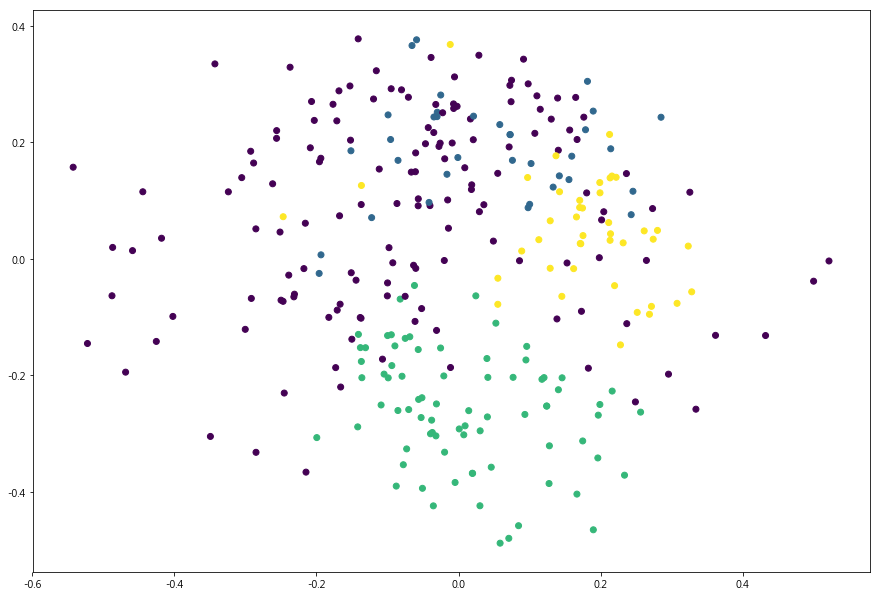

In [32]:
plt.figure(figsize=(15, 10))
plt.subplots_adjust(bottom=0.1)
plt.scatter(mds[:, 0], mds[:, 1], c=clustering.labels_)
plt.show()

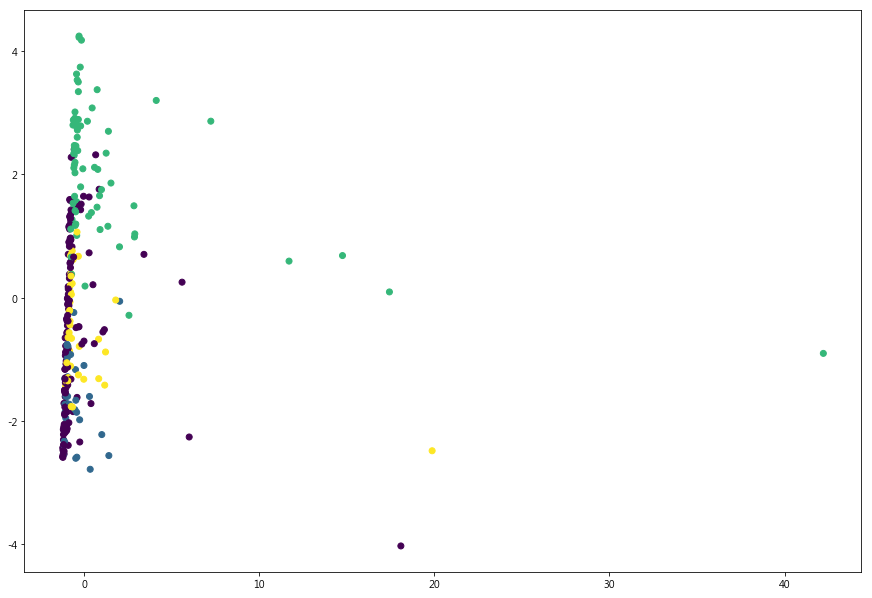

In [33]:
plt.figure(figsize=(15, 10))
plt.subplots_adjust(bottom=0.1)
plt.scatter(pca_picture[:, 0], pca_picture[:, 1], c=clustering.labels_)
plt.show()

# 繪製盒鬚圖

## 一. 抓出標準差

In [34]:
SD = np.std(NAV, axis=1, ddof=1)
SD = pd.DataFrame(data={'SD':SD, 'label':clustering.labels_})

In [35]:
SD

,SD,label
0,0.267237,2
1,0.386449,2
2,0.137791,0
3,0.088282,1
4,0.029950,0
5,0.915860,1
6,0.780828,1
7,0.584385,1
8,0.185645,2
9,0.102033,1


In [36]:
mean = np.mean(rate, axis=1)
mean = pd.DataFrame(data={'mean':mean, 'label':clustering.labels_})

In [37]:
mean

,mean,label
0,0.000316,2
1,0.002532,2
2,0.001539,0
3,0.002394,1
4,0.000171,0
5,0.000575,1
6,-0.000563,1
7,0.003073,1
8,0.001485,2
9,-0.000416,1


## 二.繪圖

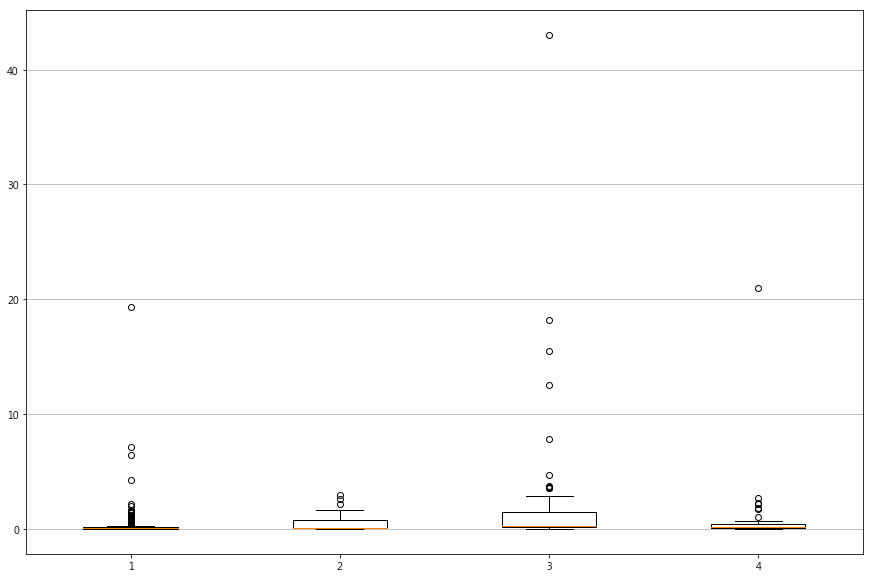

In [38]:
plt.figure(figsize=(15, 10))
plt.grid(axis='y')
plt.boxplot([SD[SD['label'] == 0]['SD'].values,
             SD[SD['label'] == 1]['SD'].values,
             SD[SD['label'] == 2]['SD'].values,
             SD[SD['label'] == 3]['SD'].values])
plt.show()

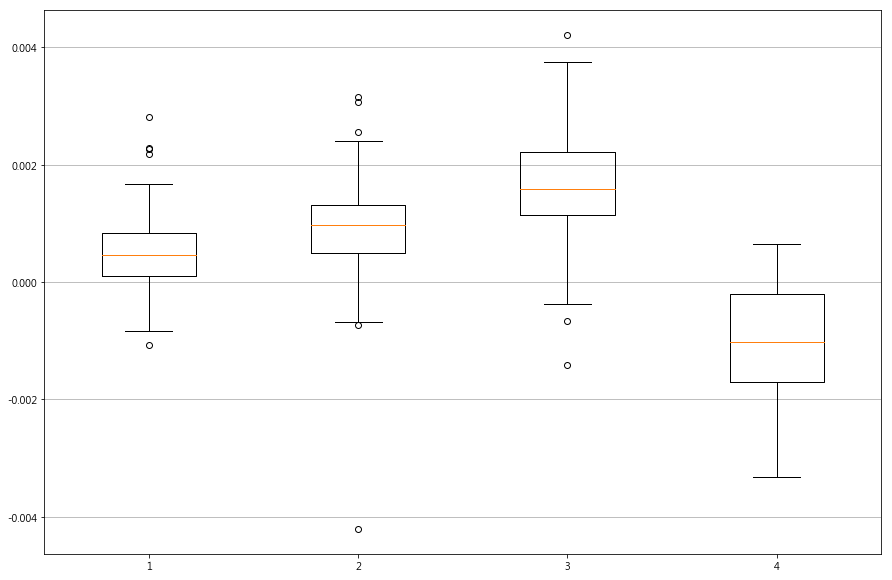

In [39]:
plt.figure(figsize=(15, 10))
plt.grid(axis='y')
plt.boxplot([mean[mean['label'] == 0]['mean'].values,
             mean[mean['label'] == 1]['mean'].values,
             mean[mean['label'] == 2]['mean'].values,
             mean[mean['label'] == 3]['mean'].values])
plt.show()

# 5.抓出四支基金

In [40]:
camp = pd.DataFrame(data=clustering.labels_, index=names,columns=['label'])
name_choose = []
start = getTimeStamp(year+'-01-01')
end = getTimeStamp(year+'-12-31')
for i in range(4):
    name_choose.append(camp[camp['label'] == i].sample(n=1).index[0])

In [41]:
name_choose

['JAZB7 駿利平衡Aa.I H', 'ISZ78 景順新貨幣債Afd$', 'CRZ02 凱敏多元配置Ea$h', 'UOB20 大華亞洲$']

# 抓出四支基金各項數據

## 一. 淨值

In [42]:
NAV_choose = getNAV(name_choose, start, end)

In [43]:
NAV_choose

array([[  9.92  ,   9.99  ,  10.01  ,  10.03  ,  10.02  ,  10.03  ,
         10.03  ,  10.02  ,  10.    ,  10.    ,   9.99  ,   9.99  ,
          9.99  ,  10.    ,  10.01  ,  10.05  ,  10.03  ,  10.09  ,
         10.11  ,  10.11  ,  10.12  ,  10.14  ,  10.16  ,  10.2   ,
         10.23  ,  10.22  ,  10.22  ,  10.25  ,  10.25  ,  10.25  ,
         10.28  ,  10.28  ,  10.28  ,  10.28  ,  10.28  ,  10.31  ,
         10.31  ,  10.29  ,  10.26  ,  10.25  ,  10.24  ,  10.26  ,
         10.26  ,  10.24  ,  10.26  ,  10.25  ,  10.24  ,  10.23  ,
         10.14  ,  10.15  ,  10.15  ,  10.15  ,  10.15  ,  10.15  ,
         10.15  ,  10.15  ,  10.15  ,  10.13  ,  10.15  ,  10.14  ,
         10.14  ,  10.14  ,  10.12  ,  10.05  ,  10.05  ,  10.11  ,
         10.12  ,  10.12  ,  10.17  ,  10.16  ,  10.23  ,  10.25  ,
         10.26  ,  10.29  ,  10.29  ,  10.28  ,  10.27  ,  10.26  ,
         10.29  ,  10.27  ,  10.27  ,  10.25  ,  10.23  ,  10.23  ,
         10.21  ,  10.21  ,  10.11  ,  10.13  , 

## 二.配息

In [44]:
interest_choose = 0
for name in name_choose:
    interest_choose += (pd.read_sql(sql='select interest from interest where date between ? and ? and id = ?'
                                ,con = engine, params=[start,end,name])['interest'].sum())

In [45]:
interest_choose

0.676489

## 三. 漲跌幅

In [46]:
temp = np.zeros((len(name_choose), len(NAV_choose[0])-1))
for j in range (len(name_choose)):
    for i in range (len(NAV_choose[0])-1):
        temp[j][i] = (NAV_choose[j][i+1] - NAV_choose[j][i]) / NAV_choose[j][i]

rate_choose = []
for i in range(len(temp[0])):
    rate_choose.append((temp[0][i] + temp[1][i] + temp[2][i] + temp[3][i])/4)

In [47]:
rate_choose

[0.0018663237263869062,
 0.0029695822411944526,
 0.0032160994826325407,
 -0.001974598876323894,
 0.00236872117908138,
 0.002920092335828646,
 0.0008257557014541121,
 0.000938495582030316,
 -0.0034138343626408897,
 0.0012007727198679546,
 0.0011288577796911474,
 -0.0002528826472589557,
 -0.00047257699787191335,
 0.0033733880182369516,
 0.0028992417121971393,
 0.005027545435340937,
 0.0035362886067766934,
 0.004665940238498132,
 -0.0028376951551493763,
 -0.00015834952992811158,
 0.004358406521077463,
 0.0021775000919848375,
 0.002630440648429589,
 0.0024596507464524336,
 0.001375994264508168,
 -0.0005496839197306161,
 -0.0011505451084368513,
 0.0,
 0.001424739564587486,
 0.002212041847750279,
 0.002419740234943614,
 0.0010294927159837245,
 0.0,
 0.0,
 -0.006331983407175017,
 -0.0037286509309365557,
 0.002343235706055739,
 0.00033887151555269963,
 -0.00039440654948728974,
 -0.004783078979542781,
 0.0018209427123538624,
 0.004731365421227556,
 -0.0012011870312944892,
 0.0026174146766312274

## 四. 收益率

In [48]:
profit_choose = []
temp = NAV_choose[0][0] + NAV_choose[1][0] + NAV_choose[2][0] + NAV_choose[3][0]
for i in range(len(NAV_choose[0])):
    profit_choose.append((NAV_choose[0][i] + NAV_choose[1][i] + NAV_choose[2][i] + NAV_choose[3][i] - temp) / temp * 100)
profit_choose[-1] += interest_choose / temp * 100 

In [49]:
profit_choose

[0.0,
 -0.19998176503875656,
 -0.8441581438316371,
 -0.47260197073212445,
 -0.5513438488276423,
 -0.7786780557311657,
 -0.05756822475117694,
 -0.9216944046548818,
 -0.6271470348219972,
 -0.7064917215536299,
 -1.2826260755424537,
 -1.2304831285165483,
 -0.7456742829026108,
 -0.65148543350606,
 -1.0124924554731514,
 -0.6318941528315696,
 -0.43409756909882125,
 -0.0006781597156348469,
 0.00030140431805755237,
 -0.21829207736143286,
 -0.3324489628300515,
 0.20171483986764638,
 0.6966960812164061,
 0.8776893742168301,
 1.0847541407302068,
 1.3582032082982707,
 0.9935793345143387,
 0.9758718308277989,
 0.9758718308277989,
 1.0301999591597126,
 1.3297958513202701,
 1.122128276170757,
 0.952136240779851,
 0.952136240779851,
 0.952136240779851,
 0.7199042137077157,
 0.778602704651646,
 0.5797512058056428,
 0.34307346504201386,
 0.28407356978000464,
 0.34412838015524744,
 0.654198072368685,
 0.6943601977513798,
 0.3369700276011075,
 0.8535770287713051,
 0.8555361568387541,
 0.8509397409881998,
 

# 繪製漲跌幅對比圖

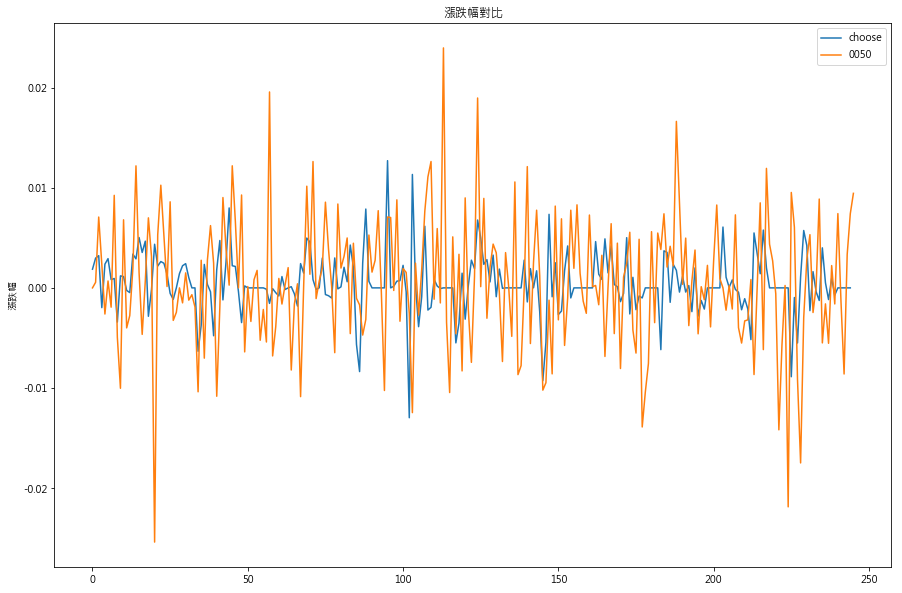

In [50]:
plt.figure(figsize=(15, 10))
plt.ylabel('漲跌幅')
plt.title('漲跌幅對比')
plt.plot(rate_choose)
plt.plot(rate_0050)
plt.legend(['choose','0050'])
plt.show()

# 繪製收益率對比圖

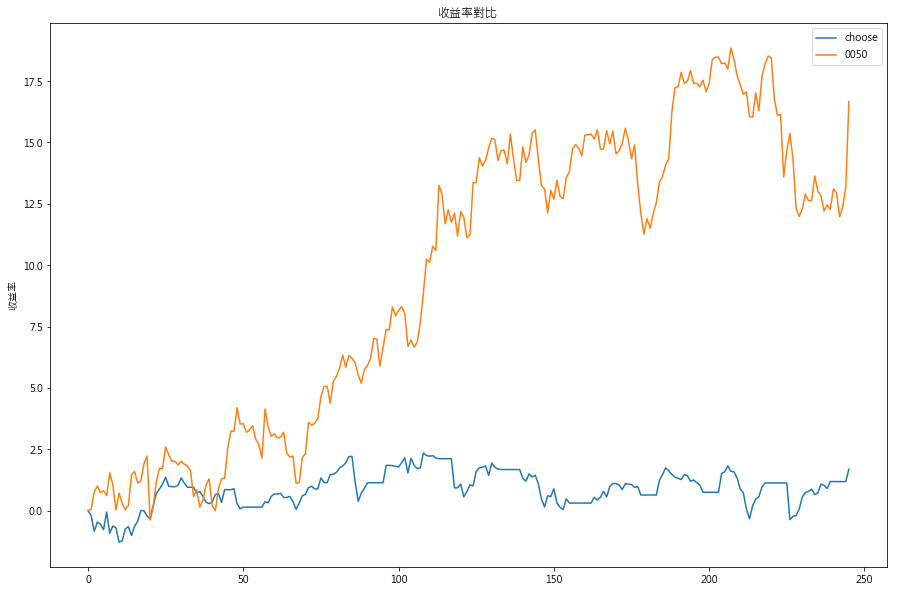

In [51]:
plt.figure(figsize=(15, 10))
plt.ylabel('收益率')
plt.title('收益率對比')
plt.plot(profit_choose)
plt.plot(profit_0050)
plt.legend(['choose','0050'])
plt.show()

In [57]:
output_file("line.html")

p = figure(plot_width=1000, plot_height=1000)

# add a line renderer
temp = []
for i in range (len(profit_choose)):
    temp.append(i+1)
p.line(temp, profit_choose, line_width=2)
script, div = components(picture, CDN)

NameError: name 'picture' is not defined